In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

## Load the Dataset

In [2]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Data Exploration and Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Check for missing values

In [4]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Display unique value in each column

In [5]:
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")

show_id: 8807
type: 2
title: 8807
director: 4528
cast: 7692
country: 748
date_added: 1767
release_year: 74
rating: 17
duration: 220
listed_in: 514
description: 8775


Dealing with Missing Values

In [6]:
# Fill with placeholders for the columns with significant missing values
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)

# Fill placeholders for date_added with a default date or a placeholder
df['date_added'].fillna('2024-01-01', inplace=True)

# Fill rating with a common placeholder or estimated rating
df['rating'].fillna('Unknown', inplace=True)

# Fill duration with a placeholder or a default value
df['duration'].fillna('Unknown', inplace=True)

Dropping Rows with Multiple Critical and Essential Missing Values

In [7]:
drop_condition = df[['director', 'cast', 'country']].isnull().sum(axis=1) > 1

drop_condition |= df[['date_added', 'rating', 'duration']].isnull().any(axis=1)

df_cleaned = df[~drop_condition].copy()

In [8]:
# Save the cleaned dataset
df_cleaned.to_csv('netflix_titles_cleaned.csv', index=False)

# Check the final number of rows after cleaning
print(f"Number of rows after cleaning: {df_cleaned.shape[0]}")

Number of rows after cleaning: 8807


## Calculate Sparsity

In this step, we simulate a user-item interaction matrix with 1000 users and the number of items in the dataset. Each element in the matrix represents whether a user has interacted with a specific item, with a high likelihood (95%) of being a zero, indicating no interaction. The code then calculates the sparsity of this matrix, which measures the proportion of zero elements.

In [9]:
user_count = 1000
item_count = len(df_cleaned)

user_item_matrix = np.random.choice([0, 1], size=(user_count, item_count), p=[0.95, 0.05])

total_elements = user_item_matrix.size
non_zero_elements = np.count_nonzero(user_item_matrix)
sparsity = (total_elements - non_zero_elements) / total_elements

print(f"Sparsity of the user-item interaction matrix: {sparsity:.4f}")

Sparsity of the user-item interaction matrix: 0.9500


The sparsity of 0.9499 in our user-item interaction matrix means that 94.99% of the entries are zeros. This tells us that most users have not interacted with most of the Netflix titles in our dataset.

## Create Implicit Ratings

In this step, we create a User-Item Interaction Matrix to capture how likely users are to interact with different Netflix titles based on their popularity. We simulate user interactions by generating a random probability matrix and comparing it to the popularity scores of each title. This results in a binary interaction matrix, where we assume an interaction occurs if the random probability is less than the title's popularity. We then multiply this matrix by the popularity scores to derive implicit ratings. To handle the large and sparse nature of this data, we convert the matrix into a sparse format, optimizing for memory usage and computational efficiency.

#### Generate Implicit Ratings

In [10]:
import random

df_cleaned['popularity_score'] = df_cleaned.apply(
    lambda row: random.randint(1, 100) if row['type'] == 'Movie' else random.randint(1, 50),
    axis=1
)

df_cleaned['popularity_score'] = df_cleaned['popularity_score'] / df_cleaned['popularity_score'].max()

print(df_cleaned[['title', 'popularity_score']].head())

                   title  popularity_score
0   Dick Johnson Is Dead              0.55
1          Blood & Water              0.25
2              Ganglands              0.49
3  Jailbirds New Orleans              0.50
4           Kota Factory              0.21


1. Assigns a random popularity score to each title based on its type. Movie gets a random score between 1 and 100, while TV Shows gets a random score between 1 and 50.
2. Normalizes the popularity score to a range between 0 and 1 by dividing each score by the maximum score i the dataset. 

#### Create a User-Item Matrix with Implicit Ratings

In [11]:
popularity_scores = df_cleaned['popularity_score'].values

interaction_probability = np.random.random((user_count, item_count))

user_item_interactions = (interaction_probability < popularity_scores)

implicit_ratings_matrix = user_item_interactions * popularity_scores

implicit_ratings_sparse = csr_matrix(implicit_ratings_matrix)

print("Sparse User-Item Ratings Matrix Shape:", implicit_ratings_sparse.shape)
print("Sample of Sparse User-Item Ratings Matrix:\n", implicit_ratings_sparse[:5, :5].todense())

Sparse User-Item Ratings Matrix Shape: (1000, 8807)
Sample of Sparse User-Item Ratings Matrix:
 [[0.   0.25 0.49 0.5  0.21]
 [0.55 0.   0.49 0.   0.  ]
 [0.   0.   0.49 0.5  0.21]
 [0.55 0.25 0.   0.5  0.  ]
 [0.55 0.   0.   0.   0.  ]]


3. 'popularity_score' extracts the array of normalized popularity scores.
4. 'interaction_probability' generates a matrix of random probabilities between 0 and 1, representing the likelihood that useres will interact with titles. 'user_count' and 'item_count' are the number of useres and items (titles) respectively. 
5. 'user_item_interactions' creates a boolean matrix where each element is 'True' if the corresponding random interaction probability is less than the title's popularity score and 'False' otherwise. 
6. 'implicit_ratings_matrix' multiplies the boolean interaction matrix by the popularity scores. The result matrix where each element represents an implicit rating, with '0' for no interaction and a positive value for interactions.
7. 'implicit_ratings_score' converts the dense implicit ratings matrix into a sparse matrix format. 

## Check for Unbalanced Response Variable

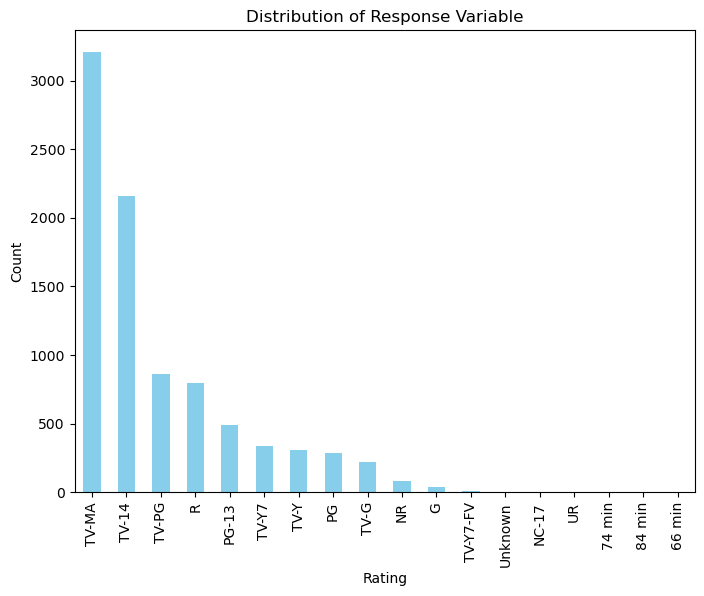

Value counts of response variable:
 TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
Unknown        4
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64


In [12]:
import matplotlib.pyplot as plt

response_variable = 'rating' 

plt.figure(figsize=(8, 6))
df_cleaned[response_variable].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Response Variable')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print("Value counts of response variable:\n", df_cleaned[response_variable].value_counts())


The rating feature in the dataset shows a significant imbalance, with the majority of titles falling under a few mature audience categories. This imbalance can influence the recommendation system's outputs, potentially leading to a bias toward more prevalent ratings. Addressing this imbalance will be crucial for developing a balanced and effective recommendation system that caters to diverse user preferences.

## Analyze Feature Distributions

#### Plot Histograms for Numerical Features

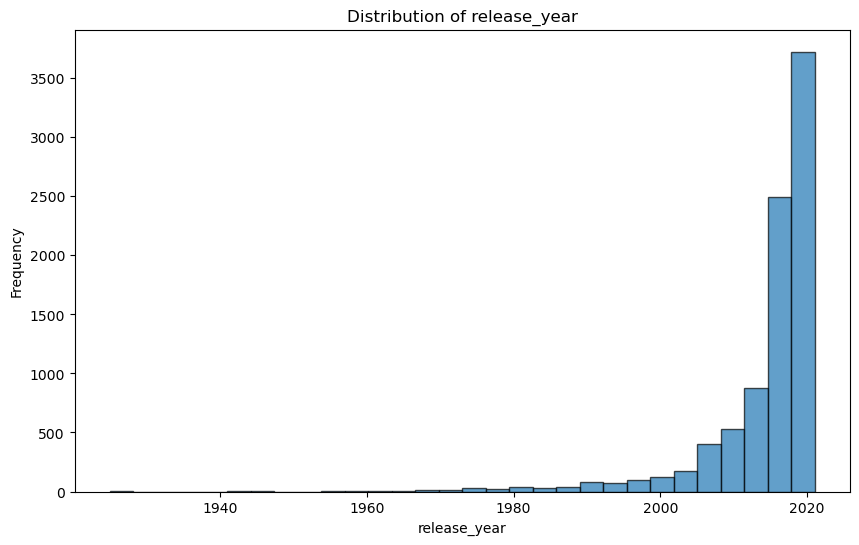

In [13]:
numerical_features = ['release_year']  

plt.figure(figsize=(10, 6))
for feature in numerical_features:
    plt.hist(df_cleaned[feature], bins=30, alpha=0.7, label=feature, edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


#### Count Plots for Categorical Features

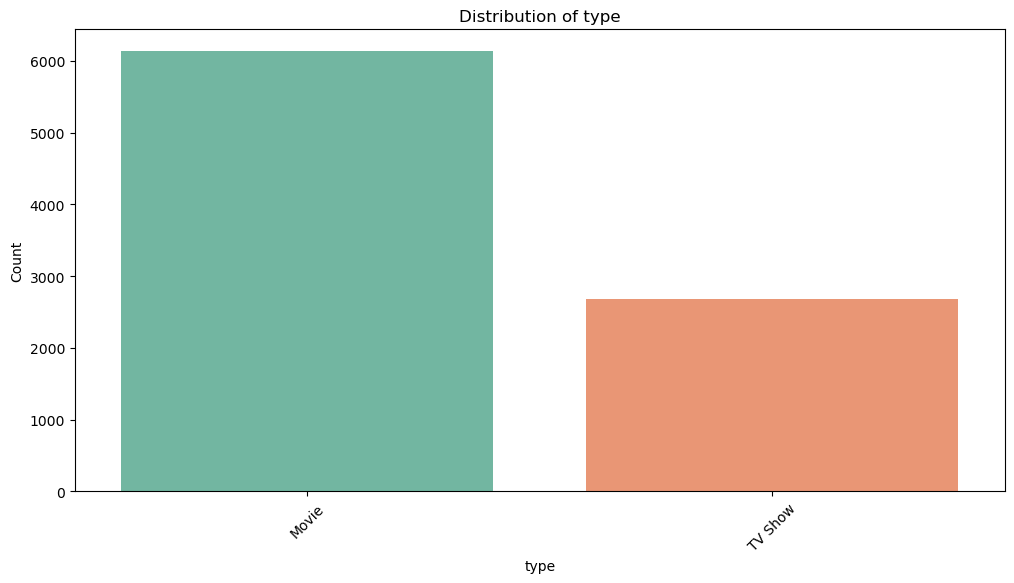

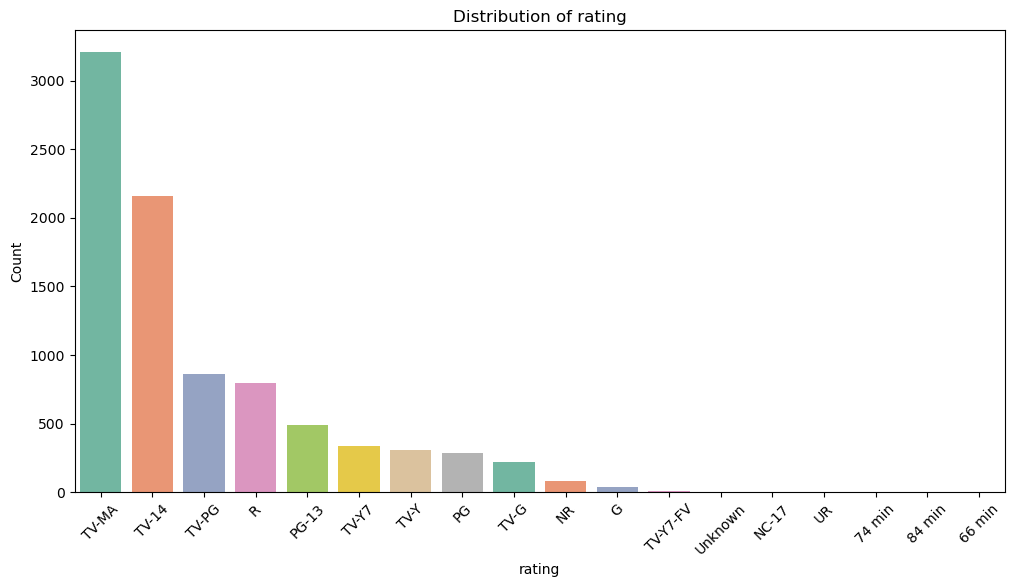

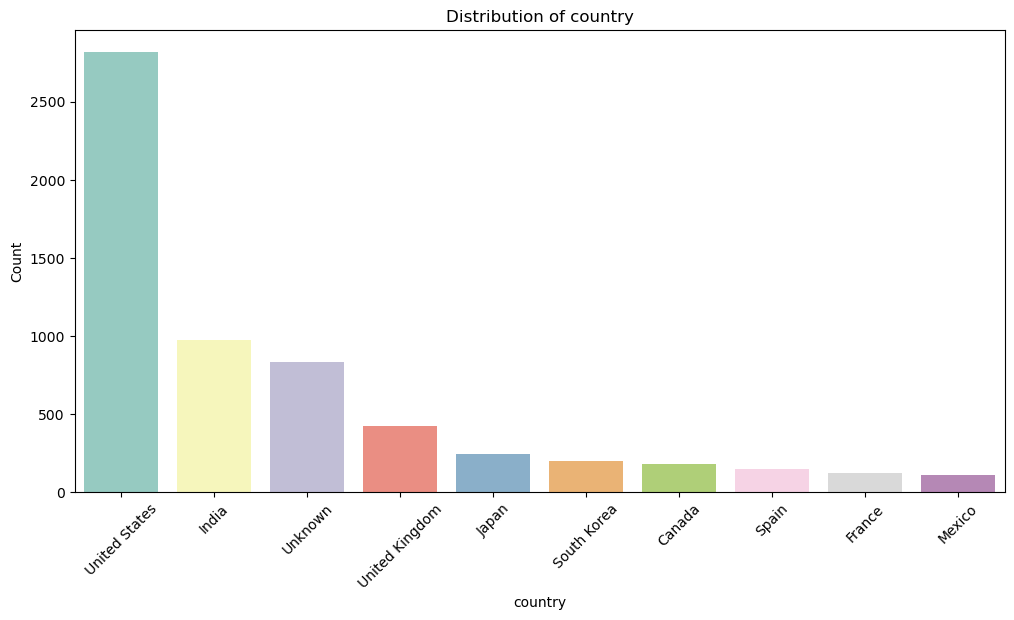

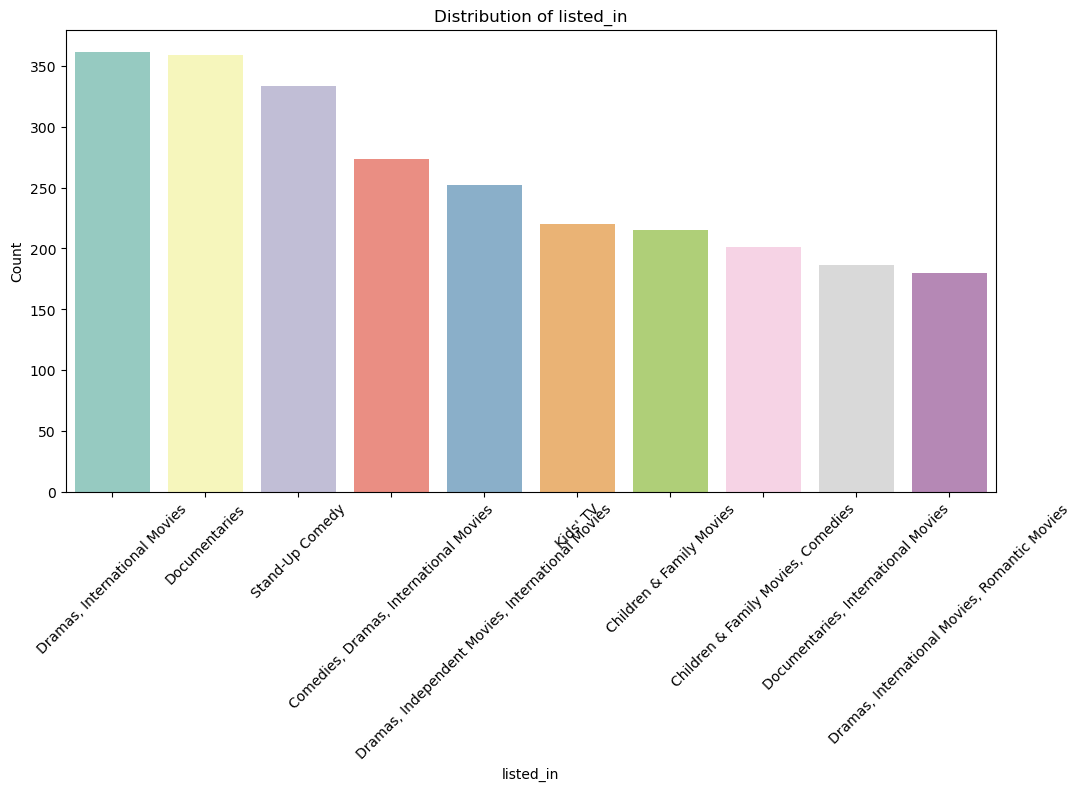

In [14]:
categorical_features = ['type', 'rating', 'country', 'listed_in'] 

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    if feature == 'country':  
        top_countries = df_cleaned[feature].value_counts().nlargest(10).index
        sns.countplot(data=df_cleaned[df_cleaned[feature].isin(top_countries)], x=feature, palette='Set3', order=top_countries)
    elif feature == 'listed_in':  
        top_genres = df_cleaned[feature].value_counts().nlargest(10).index
        sns.countplot(data=df_cleaned[df_cleaned[feature].isin(top_genres)], x=feature, palette='Set3', order=top_genres)
    else:
        sns.countplot(data=df_cleaned, x=feature, palette='Set2', order=df_cleaned[feature].value_counts().index)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  
    plt.show()


**Content Type ('type')**

- Movies dominate the dataset, compromising a significantly larger portion compared to TV Shows.
- This distribution suggests that Netflix's content library has a strong emphasis on movies, which could cater to a broad audience looking for diverse movie options.

**User Rating ('rating')**

- The most common ratings are TV-MA, TV-14, and TV-PG, indicating a substantial portion of content is geared towards mature audiences and older children.
- Less common ratings are G, NC-17, and UR, suggesting fewer titles are targeted at very young audiences or have extreme content restrictions.

**Country of Origin ('country')**

- United States leades in the number of titles, followed by India, United Kingdom and Canada. This reflects the global reach of Netflix and its significant content production or acquisition from these countries.
- Other countries contribute smaller proportions, indicating opportunities for expanding content from diverse regions to cater to internationak audiences. 

**Genre ('listed_in')**
- Dramas, Comedies, and Documentaries are among the most popular genres, indicating a hugh demand for these types of content.
- International Movies and Kids TV also feature prominetly, suggesting Netflix's efforts to cater to diverse audiences, including families and viewers interested in global content. 

## Count plots for Analyzing Correlations with Categorical Features

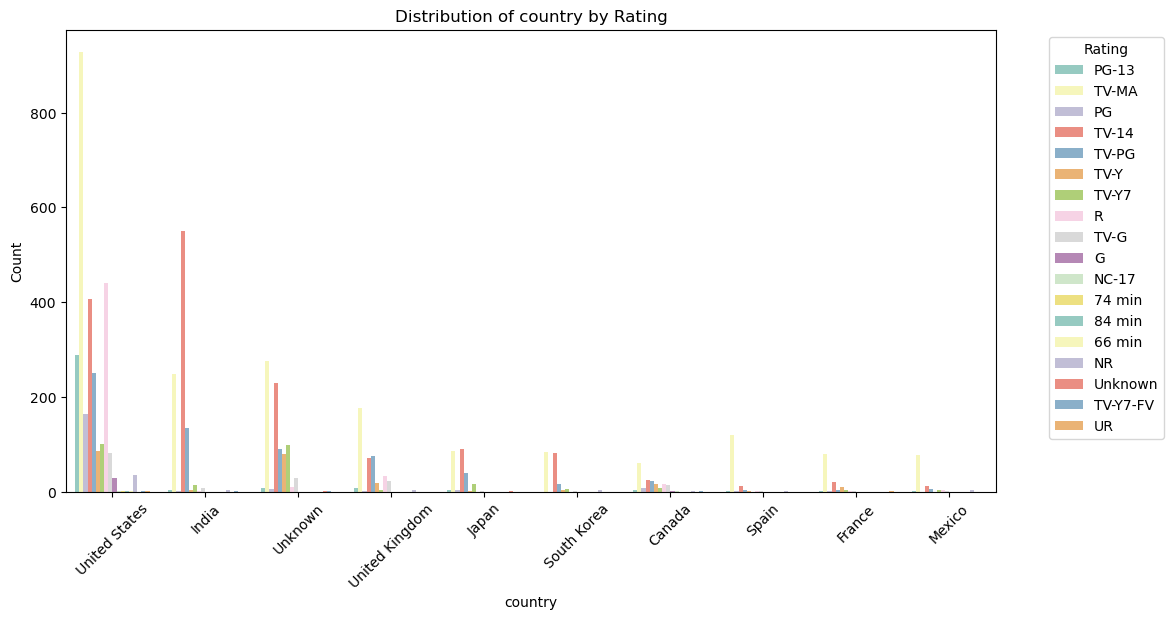

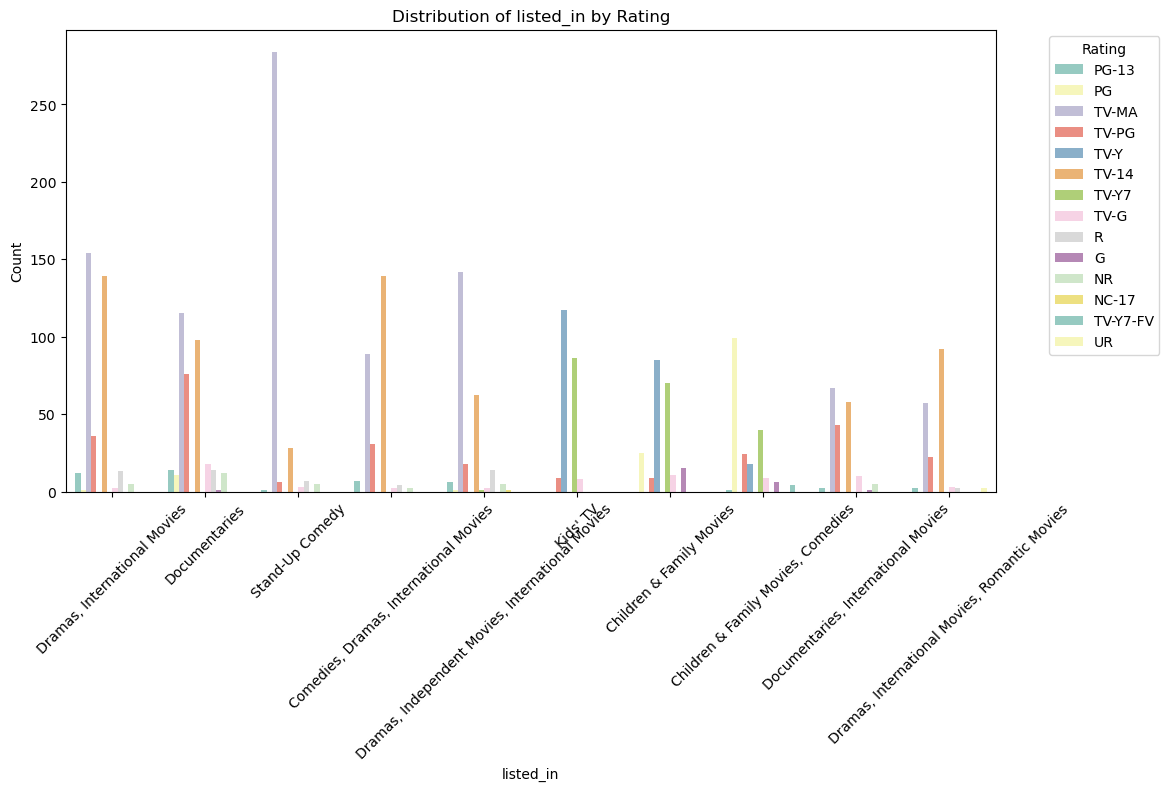

In [15]:
categorical_features = ['country', 'listed_in']  

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    if feature == 'country':  
        top_categories = df_cleaned[feature].value_counts().nlargest(10).index
        data = df_cleaned[df_cleaned[feature].isin(top_categories)]
    elif feature == 'listed_in':  
        top_categories = df_cleaned[feature].value_counts().nlargest(10).index
        data = df_cleaned[df_cleaned[feature].isin(top_categories)]
    else:
        data = df_cleaned
    
    sns.countplot(data=data, x=feature, hue='rating', palette='Set3', order=top_categories if 'top_categories' in locals() else None)
    plt.title(f'Distribution of {feature} by Rating')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45) 
    plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


#### Country of Origin (country)

Insights:

- United States leads in content production, with a high concentration of TV-MA and TV-14 rated content.
- India also features prominently, with a notable presence of TV-MA content, reflecting regional preferences.
- Other countries like United Kingdom and Canada show diverse rating distributions across various genres and content types.

Implications:

- Regional preferences influence rating distributions, informing targeted content strategies and regional recommendation systems.
- Analyzing country-specific trends aids in adapting content portfolios to regional audience tastes.


#### Genre (listed_in)

Insights:

- Drama, Comedy, and International Movies are popular genres with varied rating distributions.
- Documentaries and Kids' TV are predominantly rated TV-PG and TV-Y, respectively, indicating suitability for younger audiences.
- Thrillers, Action & Adventure, and Horror Movies have a higher prevalence of TV-MA and R ratings, appealing more to mature audiences.

Implications:

- Genre-specific rating insights enhance genre-based recommendation systems.
- Tailoring content recommendations based on genre preferences and rating compatibility improves user engagement and satisfaction.

## Time Series Plot for Trends

/var/folders/90/5dzpzv914s7cw6fyj42z9xpc0000gn/T/ipykernel_23887/4294744479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_added'] = pd.to_datetime(data['date_added'])


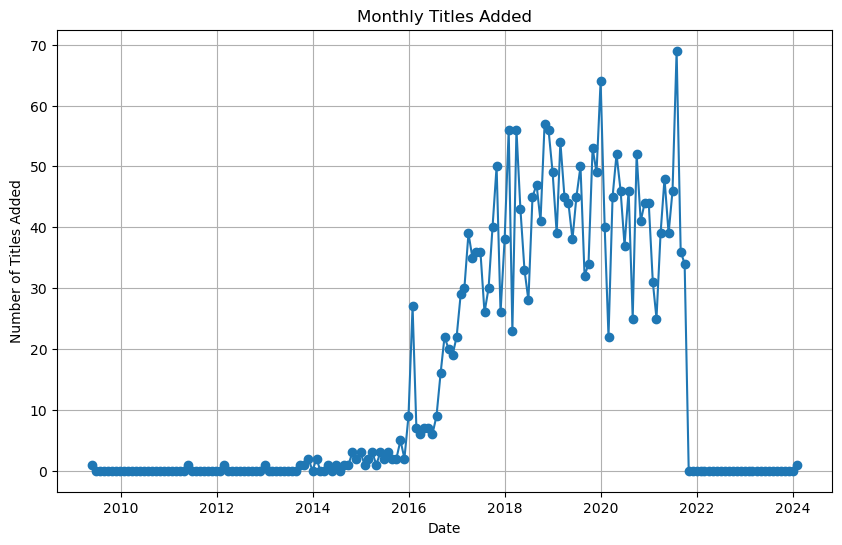

In [16]:
import pandas as pd

# Convert date_added to datetime
data['date_added'] = pd.to_datetime(data['date_added'])

# Time series plot of count per month
monthly_counts = data.resample('M', on='date_added').size()
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Titles Added')
plt.title('Monthly Titles Added')
plt.grid(True)
plt.show()


**Increasing Trend** : Over the years, there is a general upward trend in the number of titles added each month. This suggests Netflix's expanding content library and its efforts to increase its content offerings to attract and retain subscribers.

**Notable Spikes** : There are specific years with notable spikes in content additions, reflecting periods of significant content acquisition or strategic releases. For instance, the spike in 2020 could be attributed to the increased demand for streaming services during the COVID-19 pandemic.
